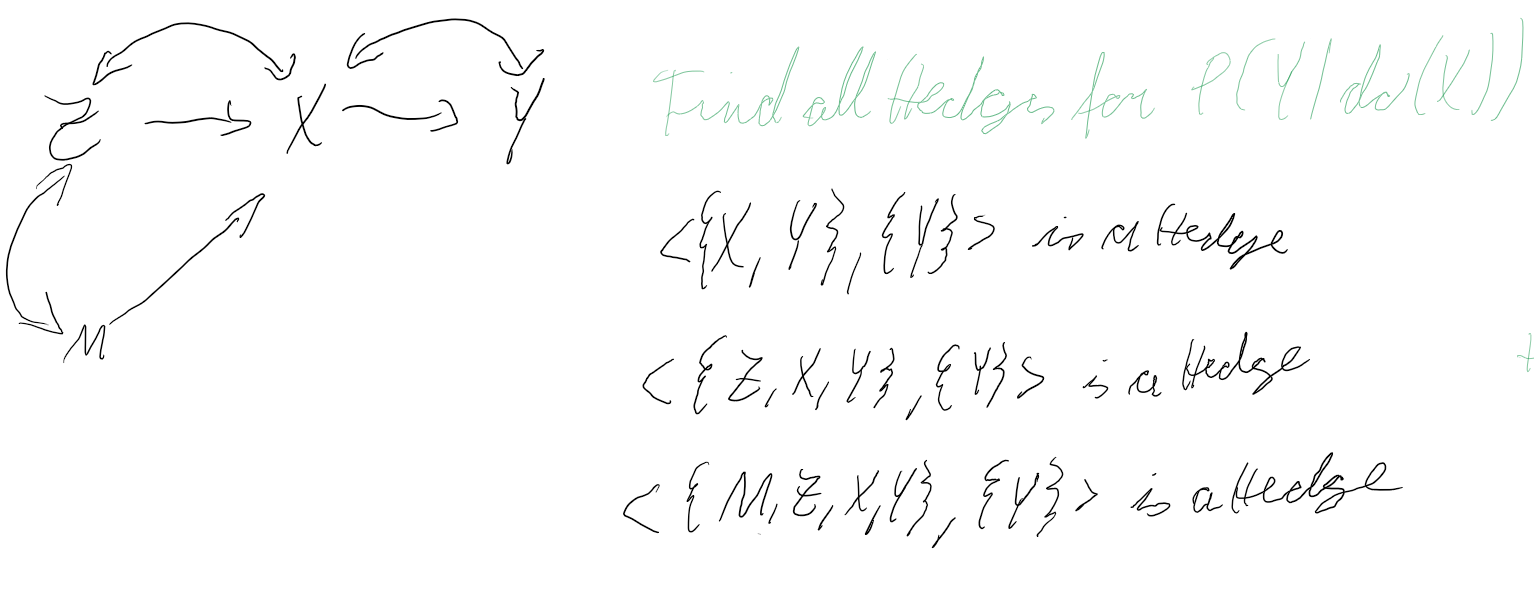

Hypothesis: $W_Z < W_M$, because $do(Z)$ destroys more Hedges than $do(M)$

In [1]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
from autobound.Query import Query
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
def synth_scm_Z_M_X_Y(n=200_000, p=0.5, seed=0):
    """
    Synthetic SCM consistent with:
        Z -> X, M -> X, X -> Y,
        Z<->M (via U_ZM), Z<->X (via U_ZX), X<->Y (via U_XY).
    Exogenous: U_ZM, U_ZX, U_XY ~ Bernoulli(p), independent.
    Endogenous are deterministic boolean functions of parents.

    Returns:
      obs:   4D array P[z,m,x,y] for P(Z=z,M=m,X=x,Y=y)
      doM:   dict m -> 3D array P[z,x,y | do(M=m)]
      doZ:   dict z -> 3D array P[m,x,y | do(Z=z)]
      p_y1_do_x1: float, P(Y=1 | do(X=1))
    """
    rng = np.random.default_rng(seed)

    # === Sample exogenous/latent variables (independent Bernoulli(p))
    U_ZM = rng.random(n) < p   # confounder for Z and M
    U_ZX = rng.random(n) < p   # confounder for Z and X
    U_XY = rng.random(n) < p   # confounder for X and Y

    # === Deterministic structural equations (boolean logic):
    # Z depends on U_ZM and U_ZX (to realize Z<->M and Z<->X)
    Z = np.logical_xor(U_ZM, U_ZX).astype(int)

    # M depends on U_ZM (to realize Z<->M without a directed edge Z->M)
    M = (U_ZM).astype(int)

    # X depends on Z, M, U_ZX, U_XY (captures Z->X, M->X, Z<->X, X<->Y)
    # e.g., X = (Z OR M) XOR (U_ZX OR U_XY)
    X = np.logical_xor(np.logical_or(Z, M), np.logical_or(U_ZX, U_XY)).astype(int)

    # Y depends on X and U_XY (captures X->Y and X<->Y)
    # e.g., Y = X XOR U_XY
    Y = np.logical_xor(X, U_XY).astype(int)

    # === Helper to tabulate a joint into a normalized array
    def joint_prob(*cols, dims):
        """
        cols: list of 1D integer arrays (each 0/1), same length n
        dims: tuple with each var's domain size (e.g., (2,2,2,2))
        returns: np.ndarray with shape=dims and probabilities summing to 1
        """
        idx = np.ravel_multi_index(cols, dims)
        counts = np.bincount(idx, minlength=np.prod(dims)).reshape(dims)
        return counts / counts.sum()

    # 1) Observational P(Z,M,X,Y)
    obs = joint_prob(Z, M, X, Y, dims=(2,2,2,2))

    # 2) Intervene on M: do(M=m)
    #    Under do(M=m), replace M's equation by a constant m (cut incoming edges to M),
    #    while Z and the latents stay as usual; X,Y recompute downstream.
    doM = {}
    for m in (0, 1):
        M_do = np.full(n, m, dtype=int)
        # X uses intervened M_do
        X_do = np.logical_xor(np.logical_or(Z, M_do), np.logical_or(U_ZX, U_XY)).astype(int)
        Y_do = np.logical_xor(X_do, U_XY).astype(int)

        doM[m] = joint_prob(Z, X_do, Y_do, dims=(2,2,2))  # P[Z, X, Y | do(M=m)]

    # 3) Intervene on Z: do(Z=z)
    #    Under do(Z=z), replace Z by constant z; M remains from its exogenous U_ZM.
    doZ = {}
    for z in (0, 1):
        Z_do = np.full(n, z, dtype=int)
        # X uses intervened Z_do
        X_do = np.logical_xor(np.logical_or(Z_do, M), np.logical_or(U_ZX, U_XY)).astype(int)
        Y_do = np.logical_xor(X_do, U_XY).astype(int)

        doZ[z] = joint_prob(M, X_do, Y_do, dims=(2,2,2))  # P[M, X, Y | do(Z=z)]

    # 4) Ground truth P(Y=1 | do(X=1))
    #    Under do(X=1), set X=1 and compute Y deterministically from (X,U_XY):
    X_do1 = np.ones(n, dtype=int)
    Y_do1 = np.logical_xor(X_do1, U_XY).astype(int)
    p_y1_do_x1 = Y_do1.mean()   # equals P(U_XY=0) = 1 - p under XOR choice

    return obs, doM, doZ, p_y1_do_x1

def joint_to_df(array, var_names):
    """
    Convert a joint probability table into a DataFrame with columns var_names + ['prob'].
    Example: array.shape = (2,2,2,2), var_names=['Z','M','X','Y'].
    """
    idx = np.indices(array.shape).reshape(len(array.shape), -1).T
    probs = array.flatten()
    df = pd.DataFrame(idx, columns=var_names)
    df['prob'] = probs
    return df

In [3]:
obs, doM, doZ, pstar = synth_scm_Z_M_X_Y(n=300000, p=0.5, seed=42)

# 1. observational
df_obs = joint_to_df(obs, ['Z','M','X','Y'])
df_obs.to_csv('data/obs.csv', index=False)



# 2. P(Z,X,Y | do(M))
records = []
for m in [0,1]:
    df = joint_to_df(doM[m], ['Z','X','Y'])
    df.insert(0, 'M_do', m)   # label which intervention this belongs to
    records.append(df)
df_doM = pd.concat(records, ignore_index=True)
df_doM.to_csv('data/doM.csv', index=False)


# 3. P(M,X,Y | do(Z))
records = []
for z in [0,1]:
    df = joint_to_df(doZ[z], ['M','X','Y'])
    df.insert(0, 'Z_do', z)
    records.append(df)
df_doZ = pd.concat(records, ignore_index=True)
df_doZ.to_csv('data/doZ.csv', index=False)


print("P(Y=1 | do(X=1)) ground truth:", pstar)

P(Y=1 | do(X=1)) ground truth: 0.50061


In [4]:
# --- DAG: Z->X, M->X, X->Y; and Z<->M, Z<->X, X<->Y
dag = DAG()
dag.from_structure(
    "Z -> X, M -> X, X -> Y, "
    "U_ZM -> Z, U_ZM -> M, "   # Z <-> M
    "U_ZX -> Z, U_ZX -> X, "   # Z <-> X
    "U_XY -> X, U_XY -> Y",    # X <-> Y
    unob="U_ZM,U_ZX,U_XY"
)

# Binary by default; can pass explicit domain sizes if you ever need non-binary
obs = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})

In [5]:
obs.load_data('data/obs.csv')      # adds equalities P(z,m,x,y) = prob
obs.add_prob_constraints()    # ensures each response-function block sums to 1

In [6]:
obs.set_estimand(obs.query('Y(X=1)=1'))   # encodes: P(Y(1)=1) - objvar = 0

prog = obs.write_program()
lower, upper = prog.run_pyomo('ipopt', verbose=False)   # pyomo solvers: glpk, ipopt..
print(f"P(Y=1 | do(X=1)) ∈ [{lower:.4f}, {upper:.4f}]")
W = upper - lower
print(f"W = {W:.4f}")


ipopt


ApplicationError: No executable found for solver 'ipopt'

In [7]:
#Simulate intervention on M
doM = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})
doM.load_data('data/obs.csv')      
doM.add_prob_constraints() 

df = pd.read_csv('data/doM.csv')
for _, row in df.iterrows():
    m, z, x, y, p = int(row.M_do), int(row.Z), int(row.X), int(row.Y), float(row.prob)
    lhs = doM.query(f'Z(M={m})={z}&X(M={m})={x}&Y(M={m})={y}')
    doM.add_constraint(lhs - Query(p))

doM.set_estimand(doM.query('Y(X=1)=1'))
prog_doM = doM.write_program()
lb, ub = prog_doM.run_pyomo('glpk', verbose=False)   # or 'ipopt' if you prefer
print('Given do(M), bounds are:')
print(f"P(Y=1 | do(X=1)) ∈ [{lb:.4f}, {ub:.4f}]")
W_M = ub - lb
print(f"W_M = {W_M:.4f}")

solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

In [ ]:
#Simulate intervention on Z
doZ = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})
doZ.load_data('data/obs.csv')      
doZ.add_prob_constraints() 

df = pd.read_csv('data/doZ.csv')
for _, row in df.iterrows():
    z, m, x, y, p = int(row.Z_do), int(row.M), int(row.X), int(row.Y), float(row.prob)
    lhs = doZ.query(f'M(Z={z})={m}&X(Z={z})={x}&Y(Z={z})={y}')
    doZ.add_constraint(lhs - Query(p))

doZ.set_estimand(doZ.query('Y(X=1)=1'))
prog_doZ = doZ.write_program()
lb, ub = prog_doZ.run_pyomo('glpk', verbose=False)
print('Given do(Z), bounds are:')
print(f"P(Y=1 | do(X=1)) ∈ [{lb:.4f}, {ub:.4f}]")
W_Z = ub - lb
print(f"W_Z = {W_Z:.4f}")

Given do(Z), bounds are:
P(Y=1 | do(X=1)) ∈ [0.3742, 0.7498]
W_Z = 0.3756
